# Learning subgrid parameterizations offline

Here we will use a training dataset to learn some parameterizations of B with increasing complexity. This can then serve as a starting ground for learning parameterizations in different setups.

In [3]:
%load_ext autoreload
%autoreload 2

In [36]:
from L96 import *
from EnKF import *
from utils import *
from parameterizations import *
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
mpl.rcParams['figure.figsize'] = (10,5)
sns.set_style('dark')
sns.set_context('talk')

In [5]:
h = xr.open_dataset('./data/L96TwoLevel_ref.nc'); h

<xarray.Dataset>
Dimensions:  (time: 200001, x: 36, y: 360)
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 ... 2e+04 2e+04 2e+04 2e+04
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
Data variables:
    X        (time, x) float64 ...
    B        (time, x) float64 ...
    Y_mean   (time, x) float64 ...
    Y2_mean  (time, x) float64 ...

In [6]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)
features.shape, targets.shape

((7200036,), (7200036,))

In [7]:
features_train, features_valid, targets_train, targets_valid = train_test_split(features, targets)
features_train.shape, features_valid.shape

((5400027,), (1800009,))

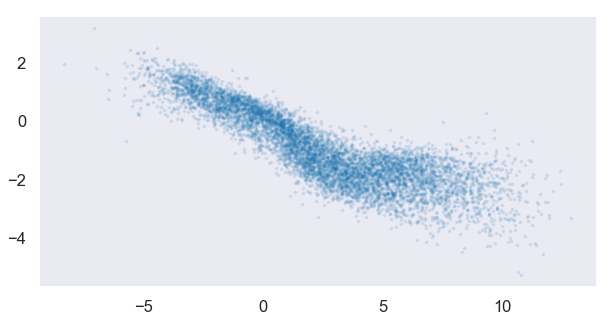

In [25]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1);

## Simple polynomials

### Learn parameterization

In [21]:
p = {}
train_mse, valid_mse = [], []
for i in range(1, 10):
    p[i] = np.polyfit(features_train, targets_train, i)
    preds_train = np.polyval(p[i], features_train)
    preds_valid = np.polyval(p[i], features_valid)
    train_mse.append(np.mean((preds_train - targets_train)**2))
    valid_mse.append(np.mean((preds_valid - targets_valid)**2))

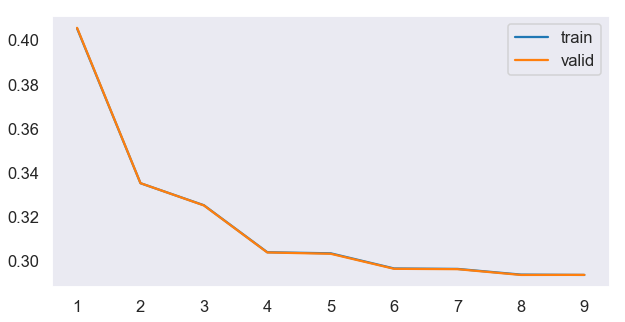

In [26]:
plt.plot(range(1, 10), train_mse, label='train')
plt.plot(range(1, 10), valid_mse, label='valid')
plt.legend();

(-5, 5)

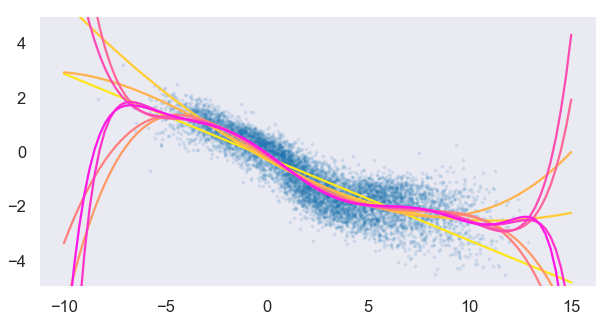

In [27]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1);
colors = sns.color_palette('spring_r', 9)
for i in range(1, 10):
    tmp = np.linspace(-10, 15, 100)
    plt.plot(tmp, np.polyval(p[i], tmp), c=colors[i-1]);
plt.ylim(-5, 5)

### Use parameterization = parameterization goal

In [50]:
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')
means = np.load('./data/L96TwoLevel_means.npy')
variances = np.load('./data/L96TwoLevel_variances.npy')

In [56]:
ce = []
for i in range(1, 5):
    param = PolyParam(p[i])
    l96_param = L96TwoLevel(noYhist=True, parameterization=param, X_init=initX, noprog=True)
    l96_param.iterate(20)
    ce.append(climate_error(l96_param, means, variances))

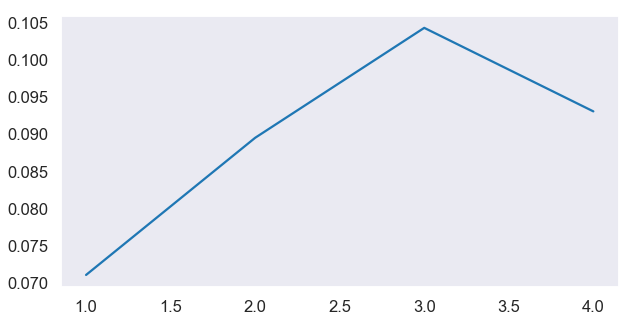

In [57]:
plt.plot(range(1, 5), ce)

## Define the parameterization problem

Start out with a wrong model

In [10]:
l96_wrong = L96TwoLevel(X_init=initX, Y_init=initY, F=10, h=1.5, c=7, b=5)

In [11]:
l96_wrong.iterate(20)

In [12]:
features_wrong = np.ravel(l96_wrong.history.X.values)
targets_wrong = np.ravel(l96_wrong.history.B.values)

In [13]:
features_wrong.shape

(7236,)

In [16]:
def create_wrong_params(npoly, nrand=10):
    p_wrong = np.polyfit(features_wrong, targets_wrong, npoly)
    p_ens = []
    n_ens = 100
    for i in range(n_ens):
        rand_idxs = np.random.randint(0, len(features_wrong), nrand)
        p_ens.append(np.polyfit(features_wrong[rand_idxs], targets_wrong[rand_idxs], npoly))
    return p_wrong, p_ens

In [18]:
npoly = 1
p_wrong, p_ens = create_wrong_params(npoly)

In [19]:
def plot_poly(p_wrong, p_ens, npoly):
    plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)
    plt.scatter(features_wrong[::10], targets_wrong[::10], s=5, c='r')
    tmp = np.linspace(-10, 15, 100)
    plt.plot(tmp, np.polyval(p[npoly], tmp), c='cyan', zorder=10, lw=5);

    plt.plot(tmp, np.polyval(p_wrong, tmp), c='green', zorder=10, lw=5);
    colors = sns.color_palette('spring_r', n_ens)
    for i, pp in enumerate(p_ens):
        plt.plot(tmp, np.polyval(pp, tmp), c=colors[i], alpha=0.5);
    plt.ylim(-5, 5)

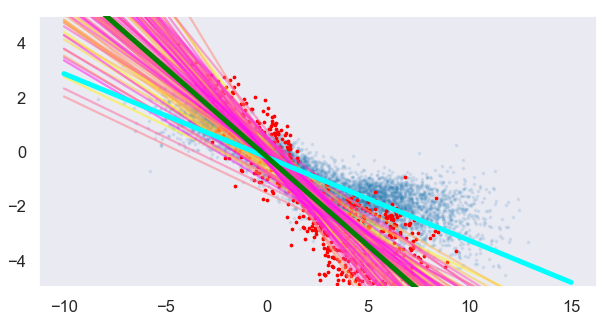

In [28]:
plot_poly(p_wrong, p_ens, npoly)

In [83]:
param = PolyParam(p_wrong)
l96_param = L96TwoLevel(noYhist=True, parameterization=param, X_init=initX)
l96_param.iterate(20)
climate_error(l96_param, means, variances)

0.17095661092771344

In [85]:
p_wrong, p[1]

(array([-0.65503361, -0.2018781 ]), array([-0.30712574, -0.21135346]))

## Learn linear regression with EnKF

### Joint state and parameter estimation - NWP

In [30]:
def set_state(l, x_a):
    l.set_state(x_a[:-len(l.parameterization.p)])
    l.parameterization.p = x_a[-len(l.parameterization.p):]

In [31]:
def get_state(l):
    return np.concatenate([l.state, l.parameterization.p])

In [32]:
def H(l):
    return l.state

In [33]:
class InitP():
    def __init__(self, p, ps):
        self.p, self.ps = p, ps
        self.i = 0
    def __call__(self, l, prior, sigma):
        if np.mean(sigma) == 0: 
            l.parameterization.p = self.p
        else:
            l.parameterization.p = self.ps[self.i]
            self.i +=1

In [34]:
class L96TwoLevelParam(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    @property
    def parameters(self):
        return self.parameterization.p

In [45]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p[1]),
                         X_init=initX, Y_init=initY), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.5, 
    mp=15, 
    get_state=get_state,
    set_state=set_state,
    H=H
)

Dimensions: n = 398, m = 396


In [46]:
init_p = InitP(p_wrong, p_ens)

In [47]:
enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))

In [48]:
enkf.initialize_parameters(init_p, priors=-999, sigmas=-999)

In [49]:
enkf.l96_tru = L96TwoLevel(noprog=True, save_dt=0.01, noYhist=True, X_init=initX, Y_init=initY)

In [53]:
enkf.iterate(10)

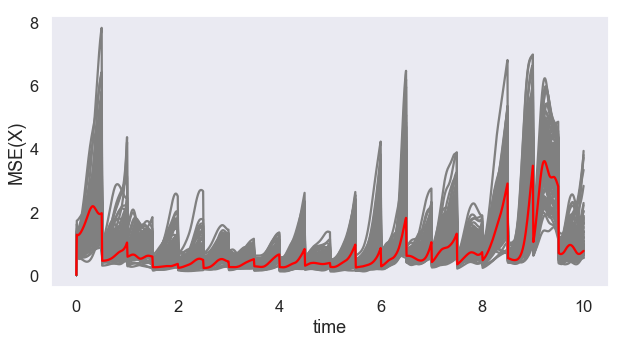

In [54]:
plot_mse(enkf)

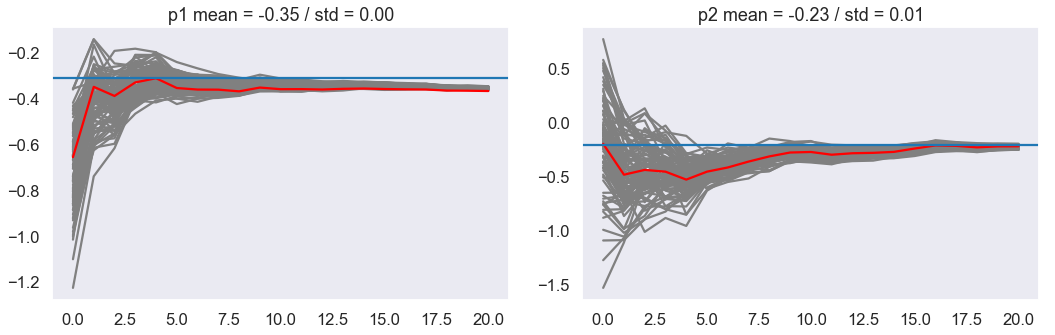

In [55]:
plot_params(enkf, names=['p1', 'p2'], truths=p[1])

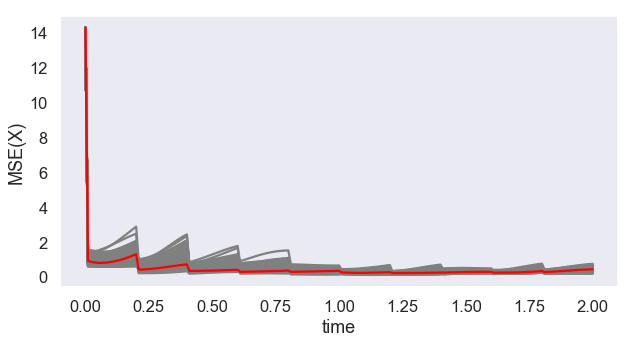

In [180]:
plot_mse(enkf)

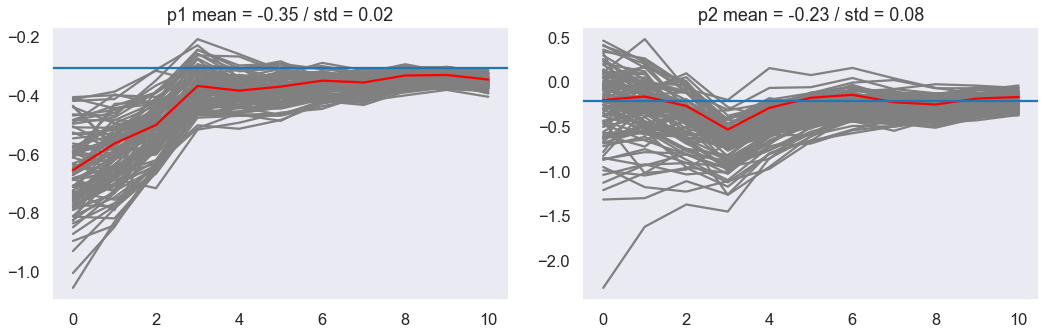

In [181]:
plot_params(enkf, names=['p1', 'p2'], truths=p[1])

### Climate setup

In [182]:
def set_state(l, x_a):
    l.parameterization.p = x_a

In [183]:
def H(l):
    return l.mean_stats(0)

In [184]:
r = 0.5

In [185]:
init_p = InitP(p_wrong, p_ens)

In [186]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p[1])), 
    nens=100, 
    obs_noise=r**2 * variances, 
    cyc_len=10, 
    mp=15, 
    get_state=lambda l: l.parameterization.p,
    set_state=set_state,
    H=H,
    y=means,
    climate=True
)

Dimensions: n = 2, m = 180


In [187]:
enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))

In [188]:
enkf.initialize_parameters(init_p, priors=-999, sigmas=-999)

In [189]:
enkf.iterate(5)

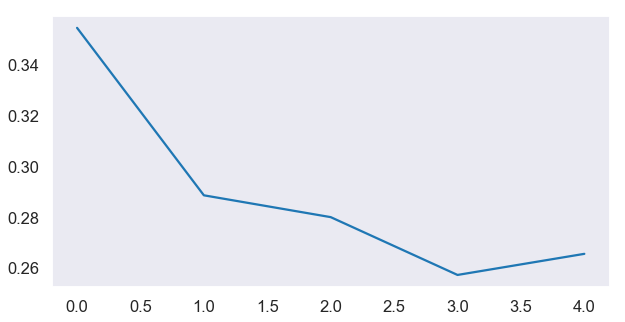

In [191]:
plt.plot(enkf.climate_error);

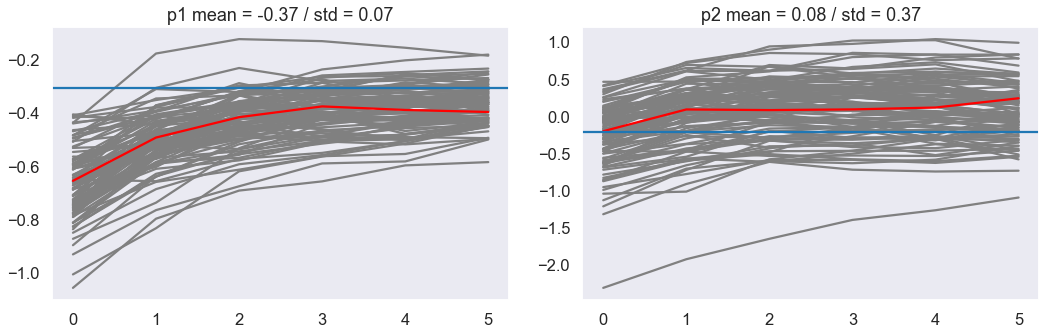

In [192]:
plot_params(enkf, names=['p1', 'p2'], truths=p[1])

## Learning higher order polynomials

### Creating initial wrong ensemble

In [228]:
def create_wrong_params(npoly, nrand=10):
    p_wrong = np.polyfit(features_wrong, targets_wrong, npoly)
    p_ens = []
    n_ens = 100
    for i in range(n_ens):
        rand_idxs = np.random.randint(0, len(features_wrong), nrand)
        p_ens.append(np.polyfit(features_wrong[rand_idxs], targets_wrong[rand_idxs], npoly))
    return p_wrong, p_ens

In [217]:
n_poly = 2
p_wrong, p_ens = create_wrong_params(npoly)

In [1]:
def plot_poly(p_wrong, p_ens, npoly):
    plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)
    plt.scatter(features_wrong[::10], targets_wrong[::10], s=5, c='r')
    tmp = np.linspace(-10, 15, 100)
    plt.plot(tmp, np.polyval(p[npoly], tmp), c='cyan', zorder=10, lw=5);

    plt.plot(tmp, np.polyval(p_wrong, tmp), c='green', zorder=10, lw=5);
    colors = sns.color_palette('spring_r', n_ens)
    for i, pp in enumerate(p_ens):
        plt.plot(tmp, np.polyval(pp, tmp), c=colors[i], alpha=0.5);
    plt.ylim(-5, 5)

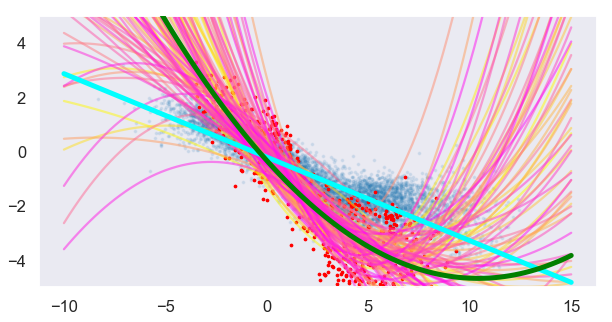

In [219]:
plot_poly(p_wrong, p_ens)

In [198]:
param = PolyParam(p_wrong)
l96_param = L96TwoLevel(noYhist=True, parameterization=param, X_init=initX)
l96_param.iterate(20)
climate_error(l96_param, means, variances)

0.18095886534168756

### Joint state and parameter estimation

In [199]:
def set_state(l, x_a):
    l.set_state(x_a[:-len(l.parameterization.p)])
    l.parameterization.p = x_a[-len(l.parameterization.p):]

In [200]:
def get_state(l):
    return np.concatenate([l.state, l.parameterization.p])

In [201]:
def H(l):
    return l.state

In [202]:
class InitP():
    def __init__(self, p, ps):
        self.p, self.ps = p, ps
        self.i = 0
    def __call__(self, l, prior, sigma):
        if np.mean(sigma) == 0: 
            l.parameterization.p = self.p
        else:
            l.parameterization.p = self.ps[self.i]
            self.i +=1

In [204]:
p_wrong

array([ 0.03997482, -0.83222995, -0.34001382])

In [205]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p_wrong)), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=15, 
    get_state=get_state,
    set_state=set_state,
    H=H
)

Dimensions: n = 399, m = 396


In [206]:
init_p = InitP(p_wrong, p_ens)

In [207]:
enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))

In [208]:
enkf.initialize_parameters(init_p, priors=-999, sigmas=-999)

In [209]:
enkf.l96_tru = L96TwoLevel(noprog=True, save_dt=0.01, noYhist=True, X_init=initX, Y_init=initY)

In [213]:
enkf.iterate(5)

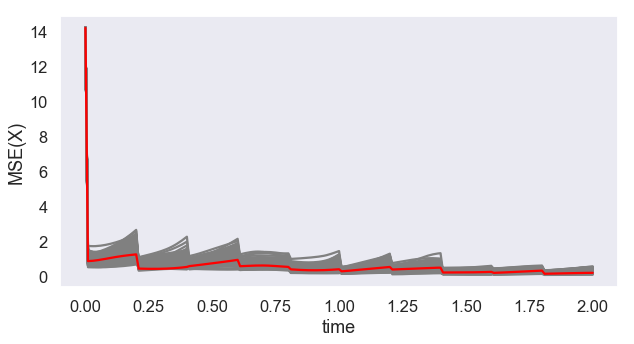

In [214]:
plot_mse(enkf)

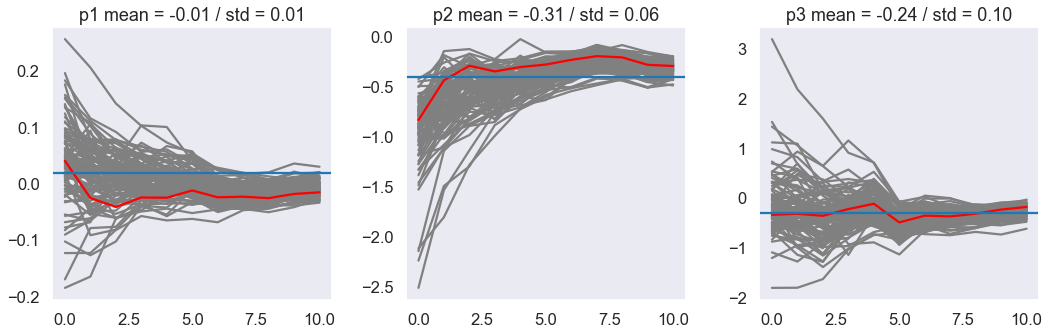

In [215]:
plot_params(enkf, names=['p1', 'p2', 'p3'], truths=p[npoly])

### Test with higher-order polynomials

In [2]:
npoly = 5
p_wrong, p_ens = create_wrong_params(npoly, nrand=100)
plot_poly(p_wrong, p_ens, npoly)

NameError: name 'create_wrong_params' is not defined

In [239]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p_wrong)), 
    nens=100, 
    obs_noise=1, 
    cyc_len=0.2, 
    mp=15, 
    get_state=get_state,
    set_state=set_state,
    H=H
)
init_p = InitP(p_wrong, p_ens)
enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))
enkf.initialize_parameters(init_p, priors=-999, sigmas=-999)
enkf.l96_tru = L96TwoLevel(noprog=True, save_dt=0.01, noYhist=True, X_init=initX, Y_init=initY)

Dimensions: n = 402, m = 396


In [252]:
enkf.iterate(10)

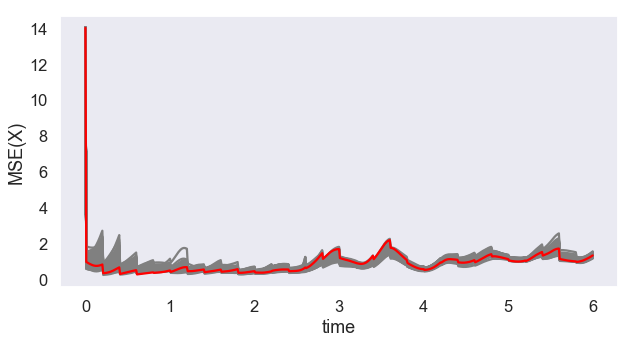

In [253]:
plot_mse(enkf)

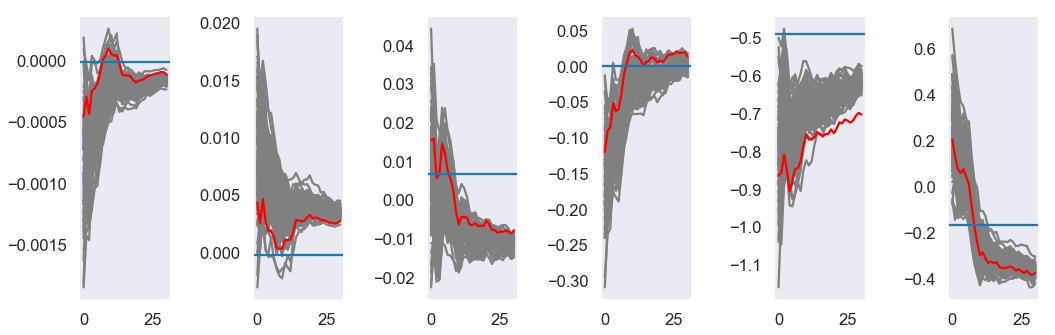

In [254]:
plot_params(enkf, names=[f'p{i+1}' for i in range(npoly+1)], truths=p[npoly], show_title=False)

In [ ]:
plot_poly(p_wrong, p_ens)

## Neural networks

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [38]:
# Normalize inputs
features_mean, targets_mean = np.mean(features_train), np.mean(targets_train)
features_std, targets_std = np.std(features_train), np.std(targets_train)

In [39]:
features_train_norm = (features_train - features_mean) / features_std
features_valid_norm = (features_valid - features_mean) / features_std

In [44]:
model = keras.models.Sequential([
    Dense(5, input_shape=(1,), activation='elu'),
    Dense(20, activation='elu'),
    Dense(1)
])
model.compile('adam', 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 20)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(features_train_norm, targets_train, batch_size=1024, epochs=5, 
          validation_data=(features_valid_norm, targets_valid))

Train on 5400027 samples, validate on 1800009 samples
Epoch 1/5
5400027/5400027 [==============================] - 31s 6us/step - loss: 0.3115 - val_loss: 0.2923
Epoch 2/5
5400027/5400027 [==============================] - 32s 6us/step - loss: 0.2917 - val_loss: 0.2916
Epoch 3/5
5400027/5400027 [==============================] - 31s 6us/step - loss: 0.2915 - val_loss: 0.2917
Epoch 4/5
5400027/5400027 [==============================] - 32s 6us/step - loss: 0.2915 - val_loss: 0.2919
Epoch 5/5
5400027/5400027 [==============================] - 32s 6us/step - loss: 0.2914 - val_loss: 0.2916


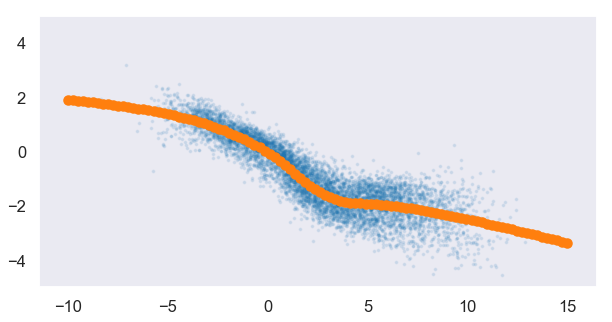

In [46]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1);
tmp = np.linspace(-10, 15, 100)
plt.scatter(tmp, model.predict((tmp-features_mean)/features_std));
plt.ylim(-5, 5);

In [87]:
class PolyParam():
    def __init__(self, p):
        self.p = p
    def __call__(self, x):
        return np.polyval(self.p, x)

In [88]:
param = PolyParam(p)

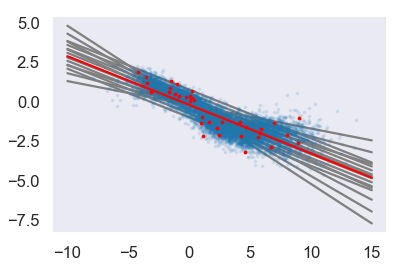

In [89]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)
tmp = np.linspace(-10, 15, 100)
plt.plot(tmp, np.polyval(tmp), c='r')
for i in np.arange(-0.5, -0.1, 0.05):
    plt.plot(tmp, PolyParam([i, p[-1]])(tmp), c='gray', zorder=0.1)
for i in np.arange(-1, 1, 0.25):
    plt.plot(tmp, PolyParam([p[0], i])(tmp), c='gray', zorder=0.1)
plt.scatter(features[-36:], targets[-36:], s=5, alpha=1, c='r')

In [36]:
l96_param = L96TwoLevel(noYhist=True, parameterization=param)

In [37]:
l96_param.iterate(20)

In [38]:
climate_error(l96_param)

0.08420750555660585

In [159]:
err_p1 = []
for p1 in tqdm(np.arange(-1, 1, 0.25)):
    l96_tmp =  L96TwoLevel(noYhist=True, parameterization=PolyParam([p1, p[1]]), noprog=True)
    l96_tmp.iterate(20)
    err_p1.append(climate_error(l96_tmp))
    
err_p2 = []
for p2 in tqdm(np.arange(-1, 1, 0.25)):
    l96_tmp = L96TwoLevel(noYhist=True, parameterization=PolyParam([p[0], p2]), noprog=True)
    l96_tmp.iterate(20)
    err_p2.append(climate_error(l96_tmp))

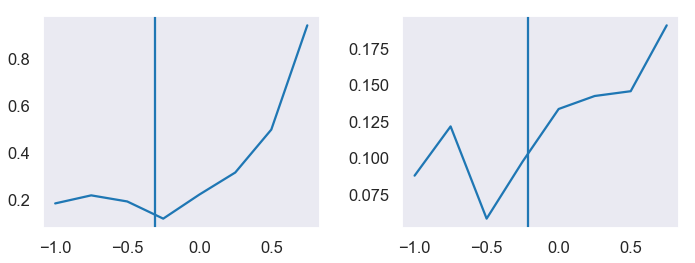

In [161]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(np.arange(-1, 1, 0.25), err_p1)
axs[0].axvline(p[0])
axs[1].plot(np.arange(-1, 1, 0.25), err_p2)
axs[1].axvline(p[1])
plt.tight_layout()

## Higher order polynomials

In [55]:
err = []
for deg in range(1, 6):
    p = np.polyfit(features, targets, deg)
    param = PolyParam(p)
    l96_tmp = L96TwoLevel(noYhist=True, parameterization=param, noprog=True)
    l96_tmp.iterate(20)
    err.append(climate_error(l96_tmp))

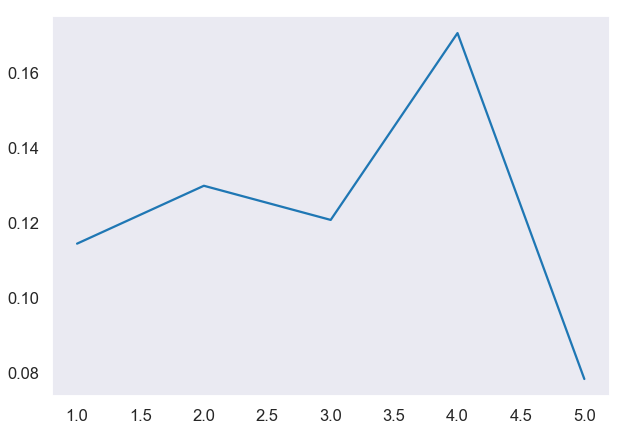

In [56]:
plt.plot(range(1, 6), err)

## Can we learn a simple linear regression with the EnKF?

### What should the initial conditions be?

In [70]:
n = features.shape[0]; n

7200036

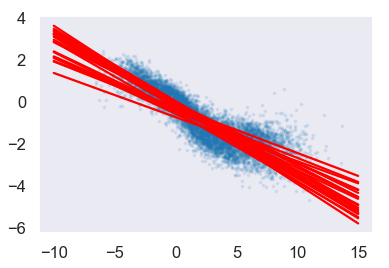

In [71]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)
ps  =[]
for i in range(20):
    idxs = np.random.randint(0, n, 10)
    p = np.polyfit(features[idxs], targets[idxs], 1)
    ps.append(p)
    #plt.scatter(features[idxs], targets[idxs], s=5, alpha=1, c='r')
    tmp = np.linspace(-10, 15, 100)
    plt.plot(tmp, np.polyval(p, tmp), c='r')

In [72]:
ps = np.array(ps)

In [73]:
ps.mean(0), ps.var(0)

(array([-0.30084021, -0.28517852]), array([0.00230562, 0.04236086]))

In [74]:
def set_state(l, x_a):
    l.parameterization.p = x_a

In [75]:
def H(l):
    return l.mean_stats(0)

In [76]:
r = 0.5

In [77]:
def init_p(l, prior, sigma):
    l.parameterization.p = prior + np.random.normal(0, np.sqrt(sigma))

In [78]:
class L96TwoLevelParam(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    @property
    def parameters(self):
        return self.parameterization.p

In [79]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p)), 
    nens=100, 
    obs_noise=r**2 * variances, 
    cyc_len=10, 
    mp=50, 
    get_state=lambda l: l.parameterization.p,
    set_state=set_state,
    H=H,
    y=means,
    climate=True
)

In [80]:
enkf.initialize(init, np.array([1]*36 + [0.1]*360))

In [81]:
enkf.initialize_parameters(init_p, priors=ps.mean(0)*2, sigmas=ps.var(0)*10)

In [82]:
enkf.iterate(5)

In [83]:
enkf.climate_error

[0.38357721320765215,
 0.2806891406452665,
 0.26429500588698085,
 0.27512400950455007,
 0.27056603611359115]

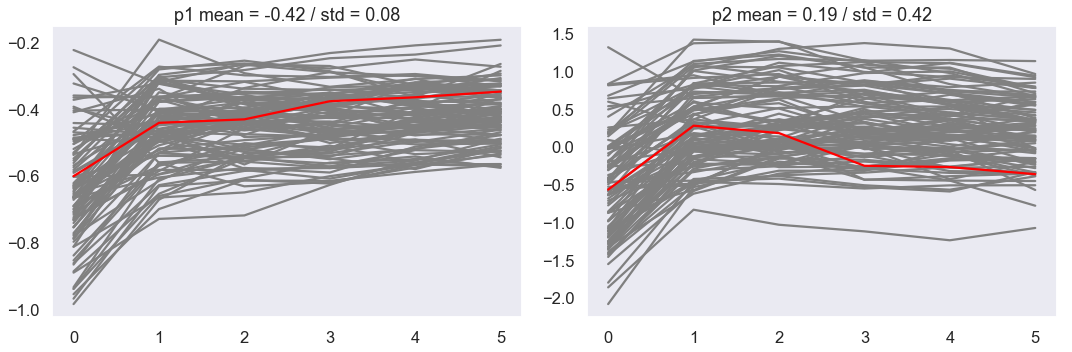

In [84]:
plot_params(enkf, names=['p1', 'p2'])

In [ ]:
p

## higher-order polynomial learning

In [57]:
p = np.polyfit(features, targets, 2); p

array([ 0.01816547, -0.40314503, -0.31091095])

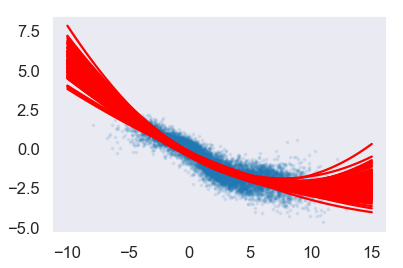

In [58]:
ps  =[]
for i in range(100):
    idxs = np.random.randint(0, n, 100)
    p = np.polyfit(features[idxs], targets[idxs], 2)
    ps.append(p)
    #plt.scatter(features[idxs], targets[idxs], s=5, alpha=1, c='r')
    tmp = np.linspace(-10, 15, 100)
    plt.plot(tmp, np.polyval(p, tmp), c='r')
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1)

In [59]:
ps = np.array(ps); ps.shape

(100, 3)

In [60]:
class InitP():
    def __init__(self, p, ps):
        self.p, self.ps = p, ps
        self.i = 0
    def __call__(self, l, prior, sigma):
        if np.mean(sigma) == 0: 
            l.parameterization.p = self.p
        else:
            l.parameterization.p = self.ps[self.i]
            self.i +=1

In [61]:
init_p = InitP(p, ps)

In [62]:
enkf = EnKF(
    l96=L96TwoLevelParam(noprog=True, save_dt=0.001, noYhist=True, parameterization=PolyParam(p)), 
    nens=100, 
    obs_noise=r**2 * variances, 
    cyc_len=5, 
    mp=50, 
    get_state=lambda l: l.parameterization.p,
    set_state=set_state,
    H=H,
    y=means,
    climate=True
)

In [63]:
enkf.initialize(init, np.array([1]*36 + [0.1]*360))

In [64]:
enkf.initialize_parameters(init_p, priors=ps.mean(0), sigmas=ps.var(0))

In [65]:
enkf.iterate(3)

In [66]:
enkf.climate_error

[0.41527602343447007, 0.4123303359050835, 0.4285318740076934]

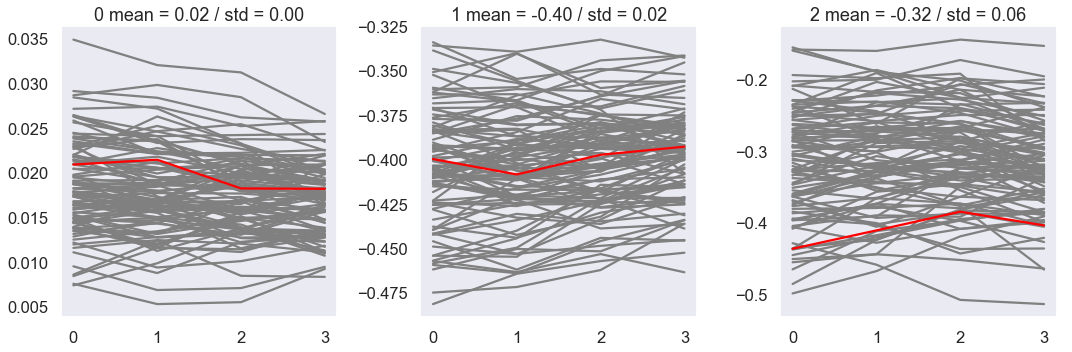

In [68]:
plot_params(enkf, names=['0', '1', '2'])

In [69]:
p

array([ 0.02088826, -0.399799  , -0.43639627])